In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from pyspark.sql.functions import count,avg
from pyspark.sql import functions as F
from pyspark.sql.types import (StructType, 
                               StructField, 
                               DateType, 
                               BooleanType,
                               DoubleType,
                               IntegerType,
                               StringType)

In [23]:
gcs_path = 'gs://pstat135-voter-file/VM2Uniform'
ca = spark.read.parquet("/".join([gcs_path, 'VM2Uniform--CA--2021-05-02']))
tx = spark.read.parquet("/".join([gcs_path, 'VM2Uniform--TX--2021-06-12']))

# Introduction

Voter turnout is an integral part of shaping how our country is run. It is also essential in gaining an understanding of how involved citizens are in our country’s affairs. With the developments technology has made in gathering information and data, we have been able to understand voting patterns and trends now more than ever. In this project, we want to explore the various demographic factors that go into voting turnout and participation. In particular, we are examining two states: California and Texas. These are two of the largest states in our country, so there is a ton of data for us to dissect and analyze. Furthermore, we will be implementing a machine learning models to predict voter turnout and determine the most influential demographic characteristics that contribute to turnout and how each of these variables do so. 


ca = spark.read\
.format("csv")\
.option("header", "true")\
.option("nullValue", "NA")\
.option("delimiter", "\t")\
.option("inferSchema", "true")\
.load("gs://pstat135proj-jay-erasmo-tyler/CA/VM2Uniform--CA--2021-05-02.tab") #change back to gs://pstat135proj-jay-erasmo-tyler/CA/VM2Uniform--CA--2021-05-02.tab

tx = spark.read\
.format("csv")\
.option("header", "true")\
.option("nullValue", "NA")\
.option("delimiter", "\t")\
.option("inferSchema", "true")\
.load("gs://pstat135proj-jay-erasmo-tyler/TX/VM2Uniform--TX--2021-06-12.tab") #change back to gs://pstat135proj-jay-erasmo-tyler/TX/VM2Uniform--TX--2021-06-12.tab

# Research Question:
## How do ethnicity, gender, age, and income demographics influence the voting habits of Californian and Texan counties?

Predictors: County election turnouts for all registered voters 2008-2016, Gender, Age, Ethnic Group, Ethnicity, Party, Estimated Home Value, Estimated Household Income, Home Owner or Renter, Absentee Voter Type, County

Predicted variable: County election turnout 2018

# Exploration

First, we filter the dataframe to include only select columns relevant to answering our research question. For both Texas and California, we include Election returns from years 2008-2018, along with features encompassing voter demographics - these include gender, age, ethnic group, specific ethnicity, political party, estimated home value, estimated household income, occupation group, homeowner or renter status, absentee voter type, and county. It is also worth noting, that the data we will be working with is a sample with stratification on the `County` variable. 


In [4]:
ca_filtered = ca.select(['ElectionReturns_G08CountyTurnoutAllRegisteredVoters', 
                         'ElectionReturns_G10CountyTurnoutAllRegisteredVoters', 
                         'ElectionReturns_G12CountyTurnoutAllRegisteredVoters', 
                         'ElectionReturns_G14CountyTurnoutAllRegisteredVoters', 
                         'ElectionReturns_G16CountyTurnoutAllRegisteredVoters', 
                         'ElectionReturns_G18CountyTurnoutAllRegisteredVoters', 
                         'Voters_Gender', 'Voters_Age', 'Ethnic_Description', 'Parties_Description',
                         'EthnicGroups_EthnicGroup1Desc', 'CommercialData_EstHomeValue',
                         'CommercialData_EstimatedHHIncome', 'CommercialData_OccupationGroup',
                         'CommercialDataLL_Home_Owner_Or_Renter', 'AbsenteeTypes_Description', 
                         'County', 'LALVOTERID'])
ca_filtered = ca_filtered.sampleBy('County', 
                                   fractions={cty: 0.15 for 
                                              cty in list(ca_filtered.select('County').toPandas()['County'])}, 
                                   seed=39)
ca_filtered.count()

3265635

In [5]:
tx_filtered = tx.select(['ElectionReturns_G08CountyTurnoutAllRegisteredVoters', 
                         'ElectionReturns_G10CountyTurnoutAllRegisteredVoters', 
                         'ElectionReturns_G12CountyTurnoutAllRegisteredVoters', 
                         'ElectionReturns_G14CountyTurnoutAllRegisteredVoters', 
                         'ElectionReturns_G16CountyTurnoutAllRegisteredVoters', 
                         'ElectionReturns_G18CountyTurnoutAllRegisteredVoters', 
                         'Voters_Gender', 'Voters_Age', 'Ethnic_Description', 'Parties_Description',
                         'EthnicGroups_EthnicGroup1Desc', 'CommercialData_EstHomeValue',
                         'CommercialData_EstimatedHHIncome', 'CommercialData_OccupationGroup',
                         'CommercialDataLL_Home_Owner_Or_Renter', 'AbsenteeTypes_Description', 
                         'County', 'LALVOTERID'])
tx_filtered = tx_filtered.sampleBy('County', 
                                   fractions={cty: 0.15 for 
                                              cty in list(tx_filtered.select('County').toPandas()['County'])}, 
                                   seed=39)

In [6]:
tx_filtered.count()

2398655

In [7]:
ca_filtered.write.save("ca_filtered.parquet")
tx_filtered.write.save("tx_filtered.parquet")

In [24]:
ca_filtered = spark.read.load("ca_filtered.parquet")
tx_filtered = spark.read.load("tx_filtered.parquet")

## Missing values

Next, we inspected the data to ensure we are not using columns with a significant number of null values. 


In [9]:
Dict_Null = {col:tx_filtered.filter(tx_filtered[col].isNull()).count() for col in tx_filtered.columns}
Dict_Null

{'ElectionReturns_G08CountyTurnoutAllRegisteredVoters': 0,
 'ElectionReturns_G10CountyTurnoutAllRegisteredVoters': 0,
 'ElectionReturns_G12CountyTurnoutAllRegisteredVoters': 0,
 'ElectionReturns_G14CountyTurnoutAllRegisteredVoters': 0,
 'ElectionReturns_G16CountyTurnoutAllRegisteredVoters': 0,
 'ElectionReturns_G18CountyTurnoutAllRegisteredVoters': 0,
 'Voters_Gender': 1591,
 'Voters_Age': 1112,
 'Ethnic_Description': 146559,
 'Parties_Description': 0,
 'EthnicGroups_EthnicGroup1Desc': 146559,
 'CommercialData_EstHomeValue': 68604,
 'CommercialData_EstimatedHHIncome': 61661,
 'CommercialData_OccupationGroup': 1054776,
 'CommercialDataLL_Home_Owner_Or_Renter': 626594,
 'AbsenteeTypes_Description': 2398655,
 'County': 0,
 'LALVOTERID': 0}

In [10]:
Dict_Null_ca = {col:ca_filtered.filter(ca_filtered[col].isNull()).count() for col in ca_filtered.columns}
Dict_Null_ca

{'ElectionReturns_G08CountyTurnoutAllRegisteredVoters': 0,
 'ElectionReturns_G10CountyTurnoutAllRegisteredVoters': 0,
 'ElectionReturns_G12CountyTurnoutAllRegisteredVoters': 0,
 'ElectionReturns_G14CountyTurnoutAllRegisteredVoters': 0,
 'ElectionReturns_G16CountyTurnoutAllRegisteredVoters': 0,
 'ElectionReturns_G18CountyTurnoutAllRegisteredVoters': 0,
 'Voters_Gender': 48228,
 'Voters_Age': 2043,
 'Ethnic_Description': 277972,
 'Parties_Description': 0,
 'EthnicGroups_EthnicGroup1Desc': 277972,
 'CommercialData_EstHomeValue': 69463,
 'CommercialData_EstimatedHHIncome': 67497,
 'CommercialData_OccupationGroup': 1637565,
 'CommercialDataLL_Home_Owner_Or_Renter': 809137,
 'AbsenteeTypes_Description': 737030,
 'County': 0,
 'LALVOTERID': 0}

Based on the dictionaries of null values above, we can see that California and Texas are both missing a significant percentage of data (over 50%) in the `CommercialData_OccupationGroup` column, so we will drop it. In addition, Texas is missing all of the values in the `AbsenteeTypes_Description` column, so we will drop that as well.

In [25]:
ca_filtered = ca_filtered.drop('AbsenteeTypes_Description', 'CommercialData_OccupationGroup')
tx_filtered = tx_filtered.drop('AbsenteeTypes_Description', 'CommercialData_OccupationGroup')

# Visualization

Our analysis of the data is aimed at the county level. However, since both California and Texas have many counties we will mostly focus on visualizations of data at the state level. Note: Trying to visualize any graphic at the county level for each county would need to be exhaustive and thus would make graphs unreadable. 

## Voting Trends 

In [26]:
def percToProp(mystr):
    return int(mystr.strip("%"))


udfpercToProp = F.udf(percToProp, IntegerType())
new_lst = []


tx_filtered = tx_filtered.withColumn('ElectionReturns_G08CountyTurnoutAllRegisteredVoters',
                                    udfpercToProp(tx_filtered.ElectionReturns_G08CountyTurnoutAllRegisteredVoters))

tx_filtered = tx_filtered.withColumn('ElectionReturns_G10CountyTurnoutAllRegisteredVoters',
                                    udfpercToProp(tx_filtered.ElectionReturns_G10CountyTurnoutAllRegisteredVoters))

tx_filtered = tx_filtered.withColumn('ElectionReturns_G12CountyTurnoutAllRegisteredVoters',
                                    udfpercToProp(tx_filtered.ElectionReturns_G12CountyTurnoutAllRegisteredVoters))

tx_filtered = tx_filtered.withColumn('ElectionReturns_G16CountyTurnoutAllRegisteredVoters',
                                    udfpercToProp(tx_filtered.ElectionReturns_G16CountyTurnoutAllRegisteredVoters))

tx_filtered = tx_filtered.withColumn('ElectionReturns_G14CountyTurnoutAllRegisteredVoters',
                                    udfpercToProp(tx_filtered.ElectionReturns_G14CountyTurnoutAllRegisteredVoters))

tx_filtered = tx_filtered.withColumn('ElectionReturns_G18CountyTurnoutAllRegisteredVoters',
                                    udfpercToProp(tx_filtered.ElectionReturns_G18CountyTurnoutAllRegisteredVoters))

tx_general_election_returns = tx_filtered.select( ['County','ElectionReturns_G08CountyTurnoutAllRegisteredVoters',
                     'ElectionReturns_G10CountyTurnoutAllRegisteredVoters', 
        'ElectionReturns_G12CountyTurnoutAllRegisteredVoters','ElectionReturns_G14CountyTurnoutAllRegisteredVoters',
        'ElectionReturns_G16CountyTurnoutAllRegisteredVoters' ,'ElectionReturns_G18CountyTurnoutAllRegisteredVoters'])


This first graphic shows the voter turnout percentage by county for Texas from the years 2008-2018.


([<matplotlib.axis.XTick at 0x7f17c14220a0>,
 [Text(0, 0, '2008'),
  Text(1, 0, '2010'),
  Text(2, 0, '2012'),
  Text(3, 0, '2014'),
  Text(4, 0, '2016'),
  Text(5, 0, '2018')])

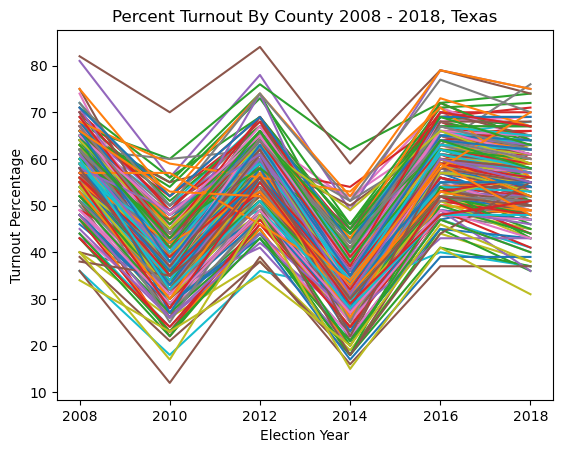

In [27]:
county_returns_tx = tx_general_election_returns.select("*").distinct().toPandas()



i = 0
names_tx = county_returns_tx.iloc[:,0]

for i in range(len(county_returns_tx)):
    plt.plot(county_returns_tx.iloc[:,[1,2,3,4,5,6]].loc[i])
    i += 1

    

plt.title("Percent Turnout By County 2008 - 2018, Texas")
plt.xlabel("Election Year")
plt.ylabel("Turnout Percentage")
plt.xticks([0,1,2,3,4,5], labels = ['2008','2010','2012','2014','2016','2018'])

Above we see a graphic for the percentage of voter turnout in Texas by county. We can notice that each individual county seem to follow similar voting trends over the period from 2008 to 2018. There seem to be dips in voter turnout in the years 2010 and 2014, while in the other years - 2008, 2012, 2016 we have some upturns in voter turnout. 

In [28]:
ca_filtered = ca_filtered.withColumn('ElectionReturns_G08CountyTurnoutAllRegisteredVoters',
                                    udfpercToProp(ca_filtered.ElectionReturns_G08CountyTurnoutAllRegisteredVoters))

ca_filtered = ca_filtered.withColumn('ElectionReturns_G10CountyTurnoutAllRegisteredVoters',
                                    udfpercToProp(ca_filtered.ElectionReturns_G10CountyTurnoutAllRegisteredVoters))

ca_filtered = ca_filtered.withColumn('ElectionReturns_G12CountyTurnoutAllRegisteredVoters',
                                    udfpercToProp(ca_filtered.ElectionReturns_G12CountyTurnoutAllRegisteredVoters))

ca_filtered = ca_filtered.withColumn('ElectionReturns_G16CountyTurnoutAllRegisteredVoters',
                                    udfpercToProp(ca_filtered.ElectionReturns_G16CountyTurnoutAllRegisteredVoters))

ca_filtered = ca_filtered.withColumn('ElectionReturns_G14CountyTurnoutAllRegisteredVoters',
                                    udfpercToProp(ca_filtered.ElectionReturns_G14CountyTurnoutAllRegisteredVoters))

ca_filtered = ca_filtered.withColumn('ElectionReturns_G18CountyTurnoutAllRegisteredVoters',
                                    udfpercToProp(ca_filtered.ElectionReturns_G18CountyTurnoutAllRegisteredVoters))

ca_general_election_returns = ca_filtered.select( ['County','ElectionReturns_G08CountyTurnoutAllRegisteredVoters',
                     'ElectionReturns_G10CountyTurnoutAllRegisteredVoters', 
        'ElectionReturns_G12CountyTurnoutAllRegisteredVoters','ElectionReturns_G14CountyTurnoutAllRegisteredVoters',
        'ElectionReturns_G16CountyTurnoutAllRegisteredVoters' ,'ElectionReturns_G18CountyTurnoutAllRegisteredVoters'])


([<matplotlib.axis.XTick at 0x7f17c11371c0>,
 [Text(0, 0, '2008'),
  Text(1, 0, '2010'),
  Text(2, 0, '2012'),
  Text(3, 0, '2014'),
  Text(4, 0, '2016'),
  Text(5, 0, '2018')])

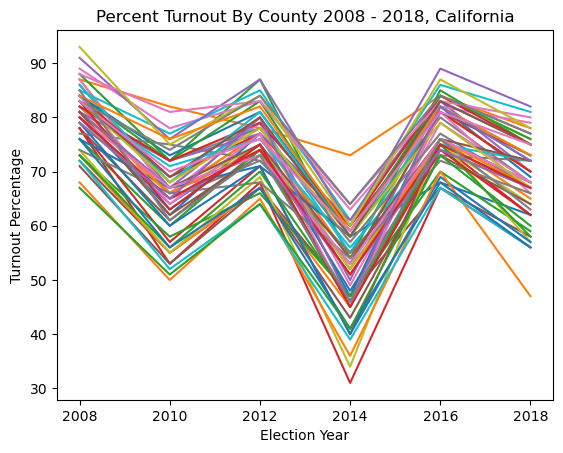

In [29]:
county_returns_ca = ca_general_election_returns.select("*").distinct().toPandas()



i = 0
names_ca = county_returns_ca.iloc[:,0]

for i in range(len(county_returns_ca)):
    plt.plot(county_returns_ca.iloc[:,[1,2,3,4,5,6]].loc[i])
    i += 1

    

plt.title("Percent Turnout By County 2008 - 2018, California")
plt.xlabel("Election Year")
plt.ylabel("Turnout Percentage")
plt.xticks([0,1,2,3,4,5], labels = ['2008','2010','2012','2014','2016','2018'])

Above we see a graphic for the percentage of voter turnout in Texas by county. We can notice that each individual county seems to follow the same voting trends over the period 2008-2018. There seem to be dips in voter turnout in the years 2010 and 2014, while in the other years - 2008, 2012, 2016 we have some upturns in voter turnout. Furthermore, the Californian counties appear to have a similar trend as the Texan counties, with regards to the down years in voter turnout and up turns in voter turnout.  

## Gender Distribution

In [30]:
import matplotlib.pyplot as plt
txgrouped = tx_filtered.select('Voters_Gender').groupby('Voters_Gender').count()
cagrouped = ca_filtered.select('Voters_Gender').groupby('Voters_Gender').count()
gendertx = [row[0] for row in txgrouped.select('Voters_Gender').collect()]
numtx = [row[0] for row in txgrouped.select('count').collect()]
genderca = [row[0] for row in cagrouped.select('Voters_Gender').collect()]
numca = [row[0] for row in cagrouped.select('count').collect()]

In [31]:
gendertx[1] = 'Null'
genderca[1] = 'Null'

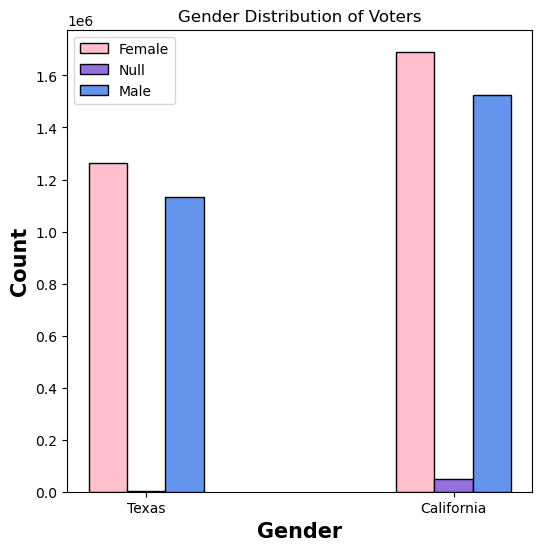

In [32]:
import numpy as np
barWidth = 0.125
fig = plt.subplots(figsize =(6, 6))
 
# set height of bar
Fe = [numtx[0], numca[0]]
N = [numtx[1], numca[1]]
M = [numtx[2], numca[2]]
 
# Set position of bar on X axis
br1 = np.arange(len(Fe))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, Fe, color ='pink', width = barWidth,
        edgecolor ='black', label ='Female')
plt.bar(br2, N, color ='mediumpurple', width = barWidth,
        edgecolor ='black', label ='Null')
plt.bar(br3, M, color ='cornflowerblue', width = barWidth,
        edgecolor ='black', label ='Male')
 
# Adding Xticks
plt.xlabel('Gender', fontweight ='bold', fontsize = 15)
plt.ylabel('Count', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(Fe))],
        ['Texas', 'California'])
plt.title('Gender Distribution of Voters')
plt.legend()
plt.show()

The above graphic shows the gender distribution of voters in both Texas and California. In both states the number of female voters is greater than the number of male voters. 

## Ethnic Demographics

In [33]:
txgrouped2 = tx_filtered.select('EthnicGroups_EthnicGroup1Desc').groupby('EthnicGroups_EthnicGroup1Desc').count()
cagrouped2 = ca_filtered.select('EthnicGroups_EthnicGroup1Desc').groupby('EthnicGroups_EthnicGroup1Desc').count()
ethtx = [row[0] for row in txgrouped2.select('EthnicGroups_EthnicGroup1Desc').collect()]
numtx2 = [row[0] for row in txgrouped2.select('count').collect()]
ethca = [row[0] for row in cagrouped2.select('EthnicGroups_EthnicGroup1Desc').collect()]
numca2 = [row[0] for row in cagrouped2.select('count').collect()]

In [34]:
ethtx.pop(2)
numtx2.pop(2)
ethca.pop(2)
numca2.pop(2)

277972

Text(0.5, 1.0, 'Ethnic Distribution of Texan Voters who Specified Ethnicity')

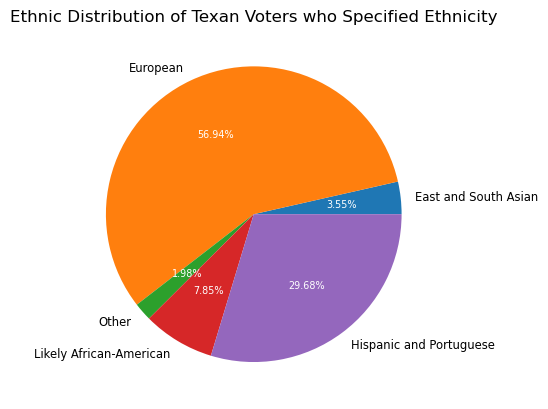

In [35]:
fig, ax = plt.subplots()
patches, texts, autotexts = ax.pie(numtx2, labels=ethtx,
                                           autopct='%.2f%%',
                                           textprops={'size': 'smaller'})
# Make percent texts even smaller
plt.setp(autotexts, size='x-small')
autotexts[0].set_color('white')
autotexts[1].set_color('white')
autotexts[2].set_color('white')
autotexts[3].set_color('white')
autotexts[4].set_color('white')
plt.title('Ethnic Distribution of Texan Voters who Specified Ethnicity')

The following pie chart displays the ethnic distribution of voters for Texas, and we can see that European and East/South Asians comprised the majority of voters. Together these ethnic groups comrpise 86.62% of the voting population in Texas.

Text(0.5, 1.0, 'Ethnic Distribution of Californian Voters who Specified Ethnicity')

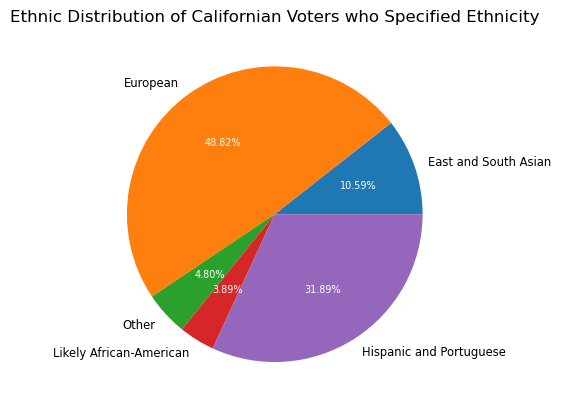

In [36]:
fig, ax = plt.subplots()
patches, texts, autotexts = ax.pie(numca2, labels=ethca,
                                           autopct='%.2f%%',
                                           textprops={'size': 'smaller'})
# Make percent texts even smaller
plt.setp(autotexts, size='x-small')
autotexts[0].set_color('white')
autotexts[1].set_color('white')
autotexts[2].set_color('white')
autotexts[3].set_color('white')
autotexts[4].set_color('white')
plt.title('Ethnic Distribution of Californian Voters who Specified Ethnicity')

The majority of Californian voters fall into the top three ethnic groups. Europeans compose 48.82% of the voter population, Hispanic and Portugese compose 31.89% of the voter population, and East adn South Asains compose 10.59% of the voting population. Together these three ethnic groups compose 91.3% of the voting population in California. 

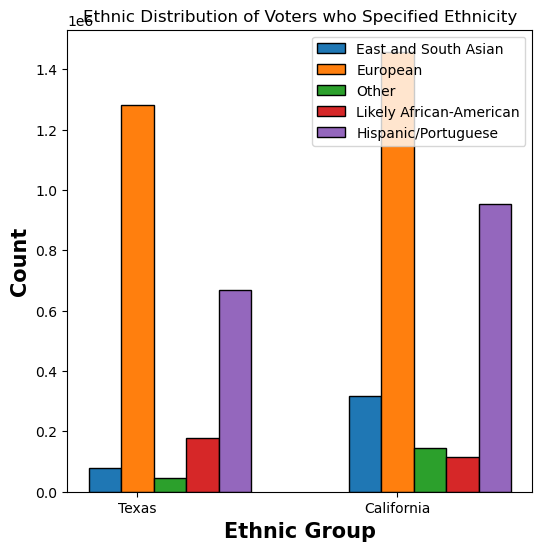

In [37]:
barWidth = 0.125
fig = plt.subplots(figsize =(6, 6))
 
# set height of bar
Asian = [numtx2[0], numca2[0]]
European = [numtx2[1], numca2[1]]
Other = [numtx2[2], numca2[2]]
LikelyAfAm = [numtx2[3], numca2[3]]
HispPort = [numtx2[4], numca2[4]]
 
# Set position of bar on X axis
br1 = np.arange(len(Asian))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
br5 = [x + barWidth for x in br4]

# Make the plot
plt.bar(br1, Asian, width = barWidth,
        edgecolor ='black', label ='East and South Asian')
plt.bar(br2, European, width = barWidth,
        edgecolor ='black', label ='European')
plt.bar(br3, Other, width = barWidth,
        edgecolor ='black', label ='Other')
plt.bar(br4, LikelyAfAm, width = barWidth,
        edgecolor ='black', label ='Likely African-American')
plt.bar(br5, HispPort, width = barWidth,
        edgecolor ='black', label ='Hispanic/Portuguese')
 
# Adding Xticks
plt.xlabel('Ethnic Group', fontweight ='bold', fontsize = 15)
plt.ylabel('Count', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(2)],
        ['Texas', 'California'])
plt.title('Ethnic Distribution of Voters who Specified Ethnicity')
 
plt.legend()
plt.show()

The bar chart above represents the count distribution more clearly, as we can see Europeans for both states comprise the majority of voters. 


## Age Distribution of Voters

In [38]:
caage = ca_filtered.na.drop(subset=["Voters_Age"]).select('Voters_Age').toPandas().values
txage = tx_filtered.na.drop(subset=["Voters_Age"]).select('Voters_Age').toPandas().values

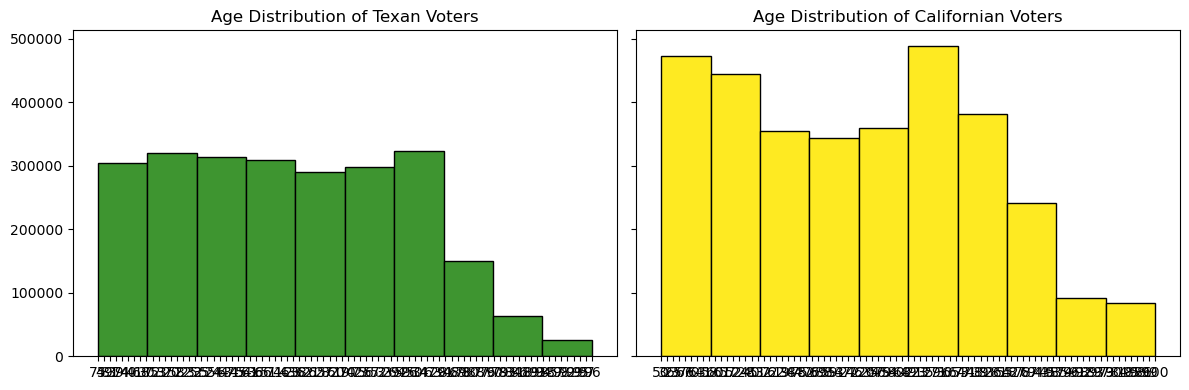

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey = True)

ax2.hist(caage, color='#feea22', edgecolor='black')
ax2.set_title('Age Distribution of Californian Voters')
ax1.hist(txage, color='#3e9530', edgecolor='black')
ax1.set_title('Age Distribution of Texan Voters')
plt.tight_layout()
plt.show()

Now let’s examine the age distribution of voters for both states. The histograms show for each state, those in the age range of 60-70 comprised the largest voter group by age in each state. It is also worth noting that the distribution of voters seems rather flat up until this 60-70 age group which means that the relative size of these voter groups by age is quite similar.  

## Household Income Distribution by State

In [40]:
cahhi = ca_filtered.na.drop(subset=["CommercialData_EstimatedHHIncome"]).select("CommercialData_EstimatedHHIncome").groupby("CommercialData_EstimatedHHIncome").count().toPandas()
txhhi = tx_filtered.na.drop(subset=["CommercialData_EstimatedHHIncome"]).select("CommercialData_EstimatedHHIncome").groupby("CommercialData_EstimatedHHIncome").count().toPandas()

In [41]:
incomes = ['$1000-14999', '$15000-24999', '$25000-34999', '$35000-49999', '$50000-74999', 
           '$75000-99999', '$100000-124999', '$125000-149999', '$150000-174999', '$175000-199999', 
           '$200000-249999', '$250000+']
mapping = {binrange: i for i, binrange in enumerate(incomes)}
keyca = cahhi['CommercialData_EstimatedHHIncome'].map(mapping)
keytx = txhhi['CommercialData_EstimatedHHIncome'].map(mapping)

In [42]:
cahhi = cahhi.iloc[keyca.argsort()]
txhhi = txhhi.iloc[keytx.argsort()]

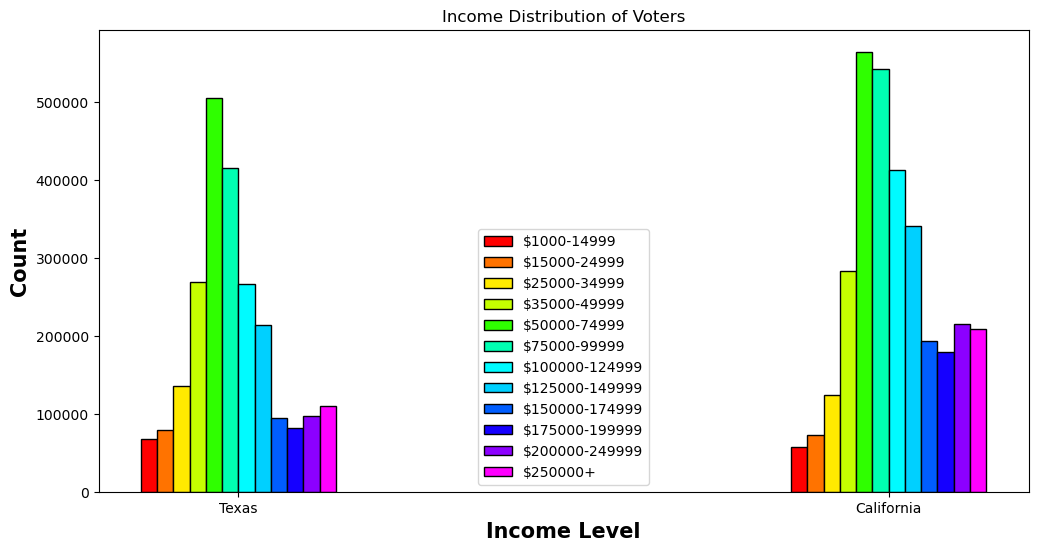

In [43]:
import numpy as np
barWidth = 0.025
fig = plt.subplots(figsize =(12, 6))
 
# set height of bar
range1 = [txhhi.loc[2, 'count'], cahhi.loc[2, 'count']]
range2 = [txhhi.loc[11, 'count'], cahhi.loc[11, 'count']]
range3 = [txhhi.loc[6, 'count'], cahhi.loc[6, 'count']]
range4 = [txhhi.loc[10, 'count'], cahhi.loc[10, 'count']]
range5 = [txhhi.loc[8, 'count'], cahhi.loc[8, 'count']]
range6 = [txhhi.loc[4, 'count'], cahhi.loc[4, 'count']]
range7 = [txhhi.loc[3, 'count'], cahhi.loc[3, 'count']]
range8 = [txhhi.loc[5, 'count'], cahhi.loc[5, 'count']]
range9 = [txhhi.loc[9, 'count'], cahhi.loc[9, 'count']]
range10 = [txhhi.loc[0, 'count'], cahhi.loc[0, 'count']]
range11 = [txhhi.loc[7, 'count'], cahhi.loc[7, 'count']]
range12 = [txhhi.loc[1, 'count'], cahhi.loc[1, 'count']]

 
# Set position of bar on X axis
br1 = np.arange(len(range1))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
br5 = [x + barWidth for x in br4]
br6 = [x + barWidth for x in br5]
br7 = [x + barWidth for x in br6]
br8 = [x + barWidth for x in br7]
br9 = [x + barWidth for x in br8]
br10 = [x + barWidth for x in br9]
br11 = [x + barWidth for x in br10]
br12 = [x + barWidth for x in br11]
 
# Make the plot
plt.bar(br1, range1, width = barWidth, color='#ff0000',
        edgecolor ='black', label ='$1000-14999')
plt.bar(br2, range2, width = barWidth, color='#ff7300',
        edgecolor ='black', label ='$15000-24999')
plt.bar(br3, range3, width = barWidth, color='#ffea00',
        edgecolor ='black', label ='$25000-34999')
plt.bar(br4, range4, width = barWidth, color='#c5ff00',
        edgecolor ='black', label ='$35000-49999')
plt.bar(br5, range5, width = barWidth, color='#2fff00',
        edgecolor ='black', label ='$50000-74999')
plt.bar(br6, range6, width = barWidth, color='#00ffb2',
        edgecolor ='black', label ='$75000-99999')
plt.bar(br7, range7, width = barWidth, color='#00fbff',
        edgecolor ='black', label ='$100000-124999')
plt.bar(br8, range8, width = barWidth, color='#00d0ff',
        edgecolor ='black', label ='$125000-149999')
plt.bar(br9, range9, width = barWidth, color='#005eff',
        edgecolor ='black', label ='$150000-174999')
plt.bar(br10, range10, width = barWidth, color='#1500ff',
        edgecolor ='black', label ='$175000-199999')
plt.bar(br11, range11, width = barWidth, color='#8c00ff',
        edgecolor ='black', label ='$200000-249999')
plt.bar(br12, range12, width = barWidth, color='#ff00ff',
        edgecolor ='black', label ='$250000+')

 
# Adding Xticks
plt.xlabel('Income Level', fontweight ='bold', fontsize = 15)
plt.ylabel('Count', fontweight ='bold', fontsize = 15)
plt.xticks([r + (5.5*barWidth) for r in range(2)],
        ['Texas', 'California'])
plt.title('Income Distribution of Voters')
plt.legend()
plt.show()

Moving on, we can see the income distribution for both states. Those in the income bracket $75000-99999 comprised the largest voter group by income in each state. It is also interesting to note that the number of people making more that $125000 is greater than the number of people making less than $35000.


In [44]:
ranked_ethnic_df = tx_filtered.select(tx_filtered.Ethnic_Description, tx_filtered.LALVOTERID) \
    .na.drop()\
    .distinct() \
    .groupBy(tx_filtered.Ethnic_Description) \
    .count() \
    .orderBy("count", ascending=False)
highest_ethnic_df = ranked_ethnic_df.limit(5).toPandas()
total_ethnic_users = ranked_ethnic_df.groupBy().sum().collect()[0][0]
ranked_ethnic_df.collect()[:5]

highest_ethnic_df_renamed = highest_ethnic_df
# Compute the percentage of top 5 workout type / total users
highest_ethnic_df_renamed['percentage'] = highest_ethnic_df['count'] \
    / total_ethnic_users * 100
print('Top 5 ethnic groups of voters in Texas:')
highest_ethnic_df_renamed

Top 5 ethnic groups of voters in Texas:


,Ethnic_Description,count,percentage
0,English/Welsh,773658,34.352798
1,Hispanic,666057,29.574983
2,Likely Af-Am (Modeled),176805,7.850687
3,Irish,122636,5.445416
4,Scots,116868,5.189299


Next, we formulated a Pandas Dataframe to list the top 5 ethnic groups of voters in Texas, as we can see English/Welsh led the way with 34.35%.


In [45]:
ranked_ethnic_df_ca = ca_filtered.select(ca_filtered.Ethnic_Description, ca_filtered.LALVOTERID) \
    .na.drop()\
    .distinct() \
    .groupBy(ca_filtered.Ethnic_Description) \
    .count() \
    .orderBy("count", ascending=False)
highest_ethnic_df_ca = ranked_ethnic_df_ca.limit(5).toPandas()
total_ethnic_users_ca = ranked_ethnic_df_ca.groupBy().sum().collect()[0][0]
ranked_ethnic_df_ca.collect()[:5]

highest_ethnic_df_renamed_ca = highest_ethnic_df_ca
# Compute the percentage of top 5 workout type / total users
highest_ethnic_df_renamed_ca['percentage'] = highest_ethnic_df_ca['count'] \
    / total_ethnic_users_ca * 100
print('Top 5 ethnic groups of voters in California:')
highest_ethnic_df_renamed_ca

Top 5 ethnic groups of voters in California:


,Ethnic_Description,count,percentage
0,Hispanic,942177,31.535585
1,English/Welsh,737810,24.695222
2,German,153702,5.144556
3,Irish,146917,4.917456
4,Chinese,129475,4.333655


We repeat the following procedure for California, and the largest ethnic group among Californian voters is Hispanic at 31.54%.


266889.8261370389


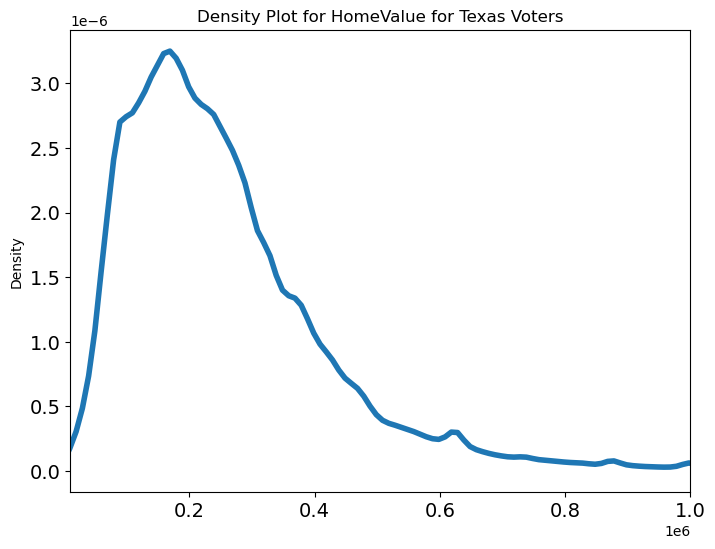

In [46]:
#remove dollar sign in age, then convert to int
from pyspark.sql.functions import expr
home_value_df = tx_filtered.select("CommercialData_EstHomeValue", "LALVOTERID", "Voters_Gender","Voters_Age").na.drop()\
.withColumn("HomeValue_Converted", expr("substring(CommercialData_EstHomeValue, 2, length(CommercialData_EstHomeValue))"))\
.toPandas()
home_value_df['HomeValue_Converted'] = home_value_df['HomeValue_Converted'].astype('int')
print(home_value_df['HomeValue_Converted'].mean())
#density plot for home_value_converted
home_value_df.HomeValue_Converted.plot.density(figsize=(8,6),
                              fontsize=14,
                              xlim=(10000,1e6),
                              linewidth=4)
plt.title('Density Plot for HomeValue for Texas Voters')
plt.show()


We also examine the feature of homevalue for each state, and we can see the mean homevalue for voters in Texas was around 266889 dollars, and for California it was around 667773 dollars. Above plotted is a density plot depicting the homevalue distribution for Texas voters, and below plotted is a density plot depicting the homevalue distribution for Californian voters.

667773.9563902178


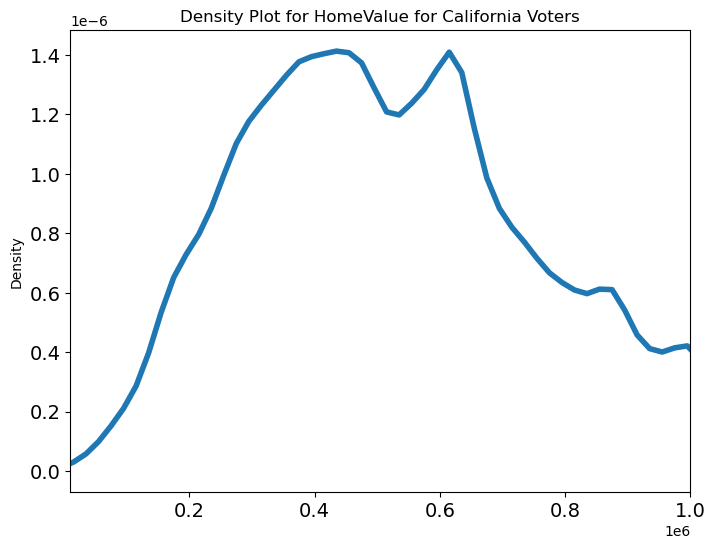

In [47]:
#remove dollar sign in age, then convert to int
home_value_df_ca = ca_filtered.select("CommercialData_EstHomeValue", "LALVOTERID", "Voters_Gender","Voters_Age").na.drop()\
.withColumn("HomeValue_Converted", expr("substring(CommercialData_EstHomeValue, 2, length(CommercialData_EstHomeValue))"))\
.toPandas()
home_value_df_ca['HomeValue_Converted'] = home_value_df_ca['HomeValue_Converted'].astype('int')
print(home_value_df_ca['HomeValue_Converted'].mean())
#density plot for home_value_converted
home_value_df_ca.HomeValue_Converted.plot.density(figsize=(8,6),
                              fontsize=14,
                              xlim=(10000,1e6),
                              linewidth=4)
plt.title('Density Plot for HomeValue for California Voters')
plt.show()

# Reformatting Data for Modeling

The original data was given on an individual voter basis. The end goal of our analysis is to predict the voter turnout for a given county in either state. Thus we must transform our predictors/columns from the individual level to the county level. For the predictors of `Age` and `CommercialData_EstHomeValue` we decided to use the median value per county. We chose the median to measure these quantities because we believe it will be more representative of the county as a whole - and unlike the mean, it will not be inflated by larger/smaller values. 

In [ ]:
# this code generates a spark dataframe of county, median age per county, and median_estHomeValue per county
ca_filtered = ca_filtered.withColumn("Voters_Age", (ca_filtered["Voters_Age"]).cast('integer'))
tx_filtered = tx_filtered.withColumn("Voters_Age", (tx_filtered["Voters_Age"]).cast('integer'))
ca_counties = ca_filtered.select('County').distinct().toPandas()
tx_counties = tx_filtered.select('County').distinct().toPandas()
ca_counties = ca_counties['County'].tolist()
tx_counties = tx_counties['County'].tolist()

def ToInt(lst):
    '''converts a list of strings to ints'''
    new_lst = []
    for item in lst:
        new_lst.append(int(item.strip("$")))
    return new_lst 


Median_ca = {}
i = 0
for county in ca_counties:
    df = ca_filtered.filter(ca_filtered.County == county)
    df = df.select('Voters_Age','CommercialData_EstHomeValue').na.drop().toPandas()
    Median_ca[i] = [county, np.median(df['Voters_Age'].tolist()), np.median(ToInt(df['CommercialData_EstHomeValue'].tolist()))]
    i += 1
    

    
Median_tx = {}

i = 0
for county in tx_counties:
    df = tx_filtered.filter(tx_filtered.County == county)
    df = df.select('Voters_Age','CommercialData_EstHomeValue').na.drop().toPandas()
    Median_tx[i] = [county, np.median(df['Voters_Age'].tolist()), np.median(ToInt(df['CommercialData_EstHomeValue'].tolist()))]
    i += 1

median_ca_pd = pd.DataFrame.from_dict(data = Median_ca, orient = 'index',
                                       columns = ['County','Median_Age','Median_EstHomeValue'])

median_tx_pd = pd.DataFrame.from_dict(data = Median_tx, orient = 'index',
                                      columns = ['County','Median_Age','Median_EstHomeValue'])

median_ca = spark.createDataFrame(median_ca_pd)
median_tx = spark.createDataFrame(median_tx_pd)

In [50]:
median_ca.write.save("median_ca.parquet")
median_tx.write.save("median_tx.parquet")

In [57]:
median_ca = spark.read.load("median_ca.parquet")
median_tx = spark.read.load("median_tx.parquet")

In [58]:
median_ca.show()
median_tx.show()

+---------------+----------+-------------------+
|         County|Median_Age|Median_EstHomeValue|
+---------------+----------+-------------------+
|      MENDOCINO|      57.0|           393332.0|
|       SISKIYOU|      61.0|           242499.0|
|       TUOLUMNE|      59.0|           336314.0|
|        ALAMEDA|      47.0|           744077.0|
|         SONOMA|      54.0|           625000.0|
|       IMPERIAL|      45.0|           217238.0|
|    LOS ANGELES|      46.0|           607064.0|
|          MARIN|      55.0|          1080896.0|
|     SAN BENITO|      47.0|           605336.0|
|      SAN DIEGO|      47.0|           594828.5|
|    SAN JOAQUIN|      47.0|           384266.0|
|        VENTURA|      50.0|           625000.0|
|         TULARE|      44.0|           242512.5|
|         MADERA|      48.0|           288042.0|
|     STANISLAUS|      46.0|           337983.0|
|      RIVERSIDE|      47.0|           391731.0|
|         ORANGE|      49.0|           714541.0|
|SAN LUIS OBISPO|   

For the predictor `CommercialDataLL_Home_Owner_Or_Renter` we decided to look at the percentage of voters in the county that are home owners, rent, or did not specify. This seemed the natural convsersion since there existed data on every voter for this column. 

In [64]:
county_ownership_tx = tx_filtered.groupBy('County','CommercialDataLL_Home_Owner_Or_Renter').agg(count('*').alias('count_owner'))
county_pop_tx = tx_filtered.groupBy('County').agg(count('*').alias('pop_total'))
county_ownership_tx = county_ownership_tx.join(county_pop_tx, county_ownership_tx.County == county_pop_tx.County, "inner")
county_ownership_tx = county_ownership_tx.withColumn('Proportion', county_ownership_tx.count_owner/county_ownership_tx.pop_total)

def owners(Str, prop):
    if Str == "Likely Homeowner":
        return prop
    return 0.0
def renters(Str, prop):
    if Str == "Likely Renter":
        return prop 
    return 0.0
def neither(Str, prop):
    if Str == None:
        return prop
    return 0.0 

udfowner = F.udf(owners, DoubleType())
udfrenter = F.udf(renters, DoubleType())
udfneither = F.udf(neither, DoubleType())

county_ownership_tx = county_ownership_tx.withColumn('Percent_Home_Owner', udfowner(county_ownership_tx.CommercialDataLL_Home_Owner_Or_Renter, 
                                                     county_ownership_tx.Proportion))
county_ownership_tx = county_ownership_tx.withColumn('Percent_Home_Renter', udfrenter(county_ownership_tx.CommercialDataLL_Home_Owner_Or_Renter, 
                                                     county_ownership_tx.Proportion))
county_ownership_tx = county_ownership_tx.withColumn('Percent_None', udfneither(county_ownership_tx.CommercialDataLL_Home_Owner_Or_Renter, 
                                                     county_ownership_tx.Proportion))


# Convert to pandas and drop duplicates 
county_ownership_tx_pd = county_ownership_tx.toPandas()
county_ownership_tx_pd = county_ownership_tx_pd.T.drop_duplicates().T

In [66]:
names_tx = county_ownership_tx_pd.iloc[:,0]
county_owner = {}
i = 0
for county in names_tx:
    owner_percentage = county_ownership_tx_pd.loc[(county_ownership_tx_pd['County']==county)&
                          (county_ownership_tx_pd['CommercialDataLL_Home_Owner_Or_Renter'] =='Likely Homeowner')]
    
    if len(list(owner_percentage['Percent_Home_Owner'])) == 0:
        owner_percentage = 0
    else:
        owner_percentage = owner_percentage.iloc[0,4]
        
        
    renter_percentage = county_ownership_tx_pd.loc[(county_ownership_tx_pd['County']==county)&
                          (county_ownership_tx_pd['CommercialDataLL_Home_Owner_Or_Renter'] =='Likely Renter')]
    
    if len(list(renter_percentage['Percent_Home_Renter'])) == 0:
        renter_percentage = 0 
    else:
        renter_percentage = renter_percentage.iloc[0,4]

    
    neither_percentage = 1- owner_percentage - renter_percentage 
    county_owner[i] = [county, owner_percentage, renter_percentage, neither_percentage]
    i += 1 
    
tx_county_ownership_pd = pd.DataFrame.from_dict(data = county_owner, orient = 'index',
                                     columns = ['County', 'Owner_Percentage', 'Renter_Percentage','None_Percentage'])

In [70]:
county_ownership_ca = ca_filtered.groupBy('County','CommercialDataLL_Home_Owner_Or_Renter').agg(count('*').alias('count_owner'))
county_pop_ca = ca_filtered.groupBy('County').agg(count('*').alias('pop_total'))
county_ownership_ca = county_ownership_ca.join(county_pop_ca, county_ownership_ca.County == county_pop_ca.County, "inner")
county_ownership_ca = county_ownership_ca.withColumn('Proportion', county_ownership_ca.count_owner/county_ownership_ca.pop_total)

udfowner = F.udf(owners, DoubleType())
udfrenter = F.udf(renters, DoubleType())
udfneither = F.udf(neither, DoubleType())
county_ownership_ca = county_ownership_ca.withColumn('Percent_Home_Owner', udfowner(county_ownership_ca.CommercialDataLL_Home_Owner_Or_Renter, 
                                                     county_ownership_ca.Proportion))
county_ownership_ca = county_ownership_ca.withColumn('Percent_Home_Renter', udfrenter(county_ownership_ca.CommercialDataLL_Home_Owner_Or_Renter, 
                                                     county_ownership_ca.Proportion))
county_ownership_ca = county_ownership_ca.withColumn('Percent_None', udfneither(county_ownership_ca.CommercialDataLL_Home_Owner_Or_Renter, 
                                                     county_ownership_ca.Proportion))


# Convert to pandas and drop duplicates 
county_ownership_ca_pd = county_ownership_ca.toPandas()
county_ownership_ca_pd = county_ownership_ca_pd.T.drop_duplicates().T
names_ca = county_ownership_ca_pd.iloc[:,0]
county_owner_ca = {}
i = 0
for county in names_ca:
    owner_percentage = county_ownership_ca_pd.loc[(county_ownership_ca_pd['County']==county)&
                          (county_ownership_ca_pd['CommercialDataLL_Home_Owner_Or_Renter'] =='Likely Homeowner')].iloc[0,4]
    renter_percentage = county_ownership_ca_pd.loc[(county_ownership_ca_pd['County']==county)&
                          (county_ownership_ca_pd['CommercialDataLL_Home_Owner_Or_Renter'] =='Likely Renter')].iloc[0,4]
    neither_percentage = 1- owner_percentage - renter_percentage 
    county_owner_ca[i] = [county, owner_percentage, renter_percentage, neither_percentage]
    i += 1 
    

ca_county_ownership_pd = pd.DataFrame.from_dict(data = county_owner_ca, orient = 'index',
                                     columns = ['County', 'Owner_Percentage', 'Renter_Percentage','None_Percentage'])



ca_county_ownership = spark.createDataFrame(ca_county_ownership_pd)
ca_county_ownership = ca_county_ownership.distinct()
tx_county_ownership = spark.createDataFrame(tx_county_ownership_pd)
tx_county_ownership = tx_county_ownership.distinct()

In [71]:
ca_county_ownership.show(10)
tx_county_ownership.show(10)

+-----------+-------------------+-------------------+-------------------+
|     County|   Owner_Percentage|  Renter_Percentage|    None_Percentage|
+-----------+-------------------+-------------------+-------------------+
|  SAN MATEO| 0.4356043753739472|0.30423576699446175| 0.2601598576315911|
|     SOLANO| 0.5054332395529515|0.24554113001058256|0.24902563043646594|
|     MADERA|0.47907771135781385|0.20248600436474049|0.31843628427744564|
|       KERN| 0.4547810517057234|0.26185839040020104| 0.2833605578940756|
| SAN BENITO|0.47472891012681495| 0.2530784782209153|0.27219261165226977|
|SANTA CLARA| 0.4543329761585856|0.32236806857755157|0.22329895526386284|
|       YUBA|0.45096731154102737|0.25600400266844564|0.29302868579052704|
|      MODOC| 0.4091503267973856|0.11372549019607843|  0.477124183006536|
|     SHASTA| 0.5035766246362755|0.22126576139670223|0.27515761396702226|
|  EL DORADO| 0.5540831295843521| 0.1860635696821516| 0.2598533007334963|
+-----------+-------------------+-----

For the `CommercialData_EstimatedHHIncome` we again decided that the median estimated household income would provide a representative statistic for the county level. Again we chose the median to protect against any inflation by extreme values.

In [77]:
def bucketMid(Str):
    Str = Str.strip("$+").split("-")
    if len(Str) > 1:
        lower = int(Str[0])
        upper = int(Str[1])
        mid = (upper+lower)/2
        return mid
    else:
        return int(Str[0])

udfbucketMid = F.udf(bucketMid, DoubleType())

# Code for Texas 
tx_income = tx_filtered.select('County','CommercialData_EstimatedHHIncome').na.drop()
tx_income = tx_income.withColumn('Income', udfbucketMid(tx_income.CommercialData_EstimatedHHIncome))
counties_tx = tx_income.select('County').distinct().toPandas()
counties_tx = counties_tx.iloc[:,0]

median_income_tx = {}
i = 0
for county in counties_tx:
    df = tx_income.filter(tx_income.County == county)
    df = df.select('Income').toPandas()
    median_income_tx[i] = [county, np.nanmedian(df['Income'].tolist())]
    i += 1 
    
median_income_tx_pd = pd.DataFrame.from_dict(data = median_income_tx, orient = 'index',
                                         columns = ['County', 'Median_Income']) 
median_income_tx = spark.createDataFrame(median_income_tx_pd)

# Code for California 
ca_income = ca_filtered.select('County','CommercialData_EstimatedHHIncome').na.drop()
ca_income = ca_income.withColumn('Income', udfbucketMid(ca_income.CommercialData_EstimatedHHIncome))
counties_ca = ca_income.select('County').distinct().toPandas()
counties_ca = counties_ca.iloc[:,0]
median_income_ca = {}
i = 0
for county in counties_ca:
    df = ca_income.filter(ca_income.County == county)
    df = df.select('Income').toPandas()
    median_income_ca[i] = [county, np.nanmedian(df['Income'].tolist())]
    i += 1 
    
median_income_ca_pd = pd.DataFrame.from_dict(data = median_income_ca, orient = 'index',
                                         columns = ['County', 'Median_Income'])
median_income_ca = spark.createDataFrame(median_income_ca_pd)

## Loading and joining all the DataFrames

In the process of reformatting our columns/predictors we created a number of dataframes. The following code joins all the dataframes for the states respectively. This is the data preparation for the modeling. 

In [94]:
ca_filtered = ca_filtered.na.fill(value='Null', subset=['Voters_Gender'])
ca_cty_gender = ca_filtered.select('Voters_Gender', 'County').groupby('County', 'Voters_Gender').count()
ca_cty_gender_totals = ca_cty_gender.groupby('County').sum('count')
ca_cty_gender = ca_cty_gender.join(ca_cty_gender_totals, on='County')
ca_cty_gender = ca_cty_gender.withColumn('PctGender', F.round(100 * (ca_cty_gender['count'] / ca_cty_gender['sum(count)']), 2))
ca_cty_female = ca_cty_gender.select('County', 'PctGender').where(ca_cty_gender['Voters_Gender'] == 'F')
ca_cty_female = ca_cty_female.withColumn('PctFemale', ca_cty_female['PctGender']).drop('PctGender')
ca_cty_male = ca_cty_gender.select('County', 'PctGender').where(ca_cty_gender['Voters_Gender'] == 'M')
ca_cty_male = ca_cty_male.withColumn('PctMale', ca_cty_male['PctGender']).drop('PctGender')
ca_cty_null = ca_cty_gender.select('County', 'PctGender').where(ca_cty_gender['Voters_Gender'] == 'Null')
ca_cty_null = ca_cty_null.withColumn('PctNullGender', ca_cty_null['PctGender']).drop('PctGender')
ca_counties = ca_filtered.join(ca_cty_female, on='County').join(ca_cty_male, on='County').join(ca_cty_null, on='County')

In [95]:
tx_filtered = tx_filtered.na.fill(value='Null', subset=['Voters_Gender'])
tx_cty_gender = tx_filtered.select('Voters_Gender', 'County').groupby('County', 'Voters_Gender').count()
tx_cty_gender_totals = tx_cty_gender.groupby('County').sum('count')
tx_cty_gender = tx_cty_gender.join(tx_cty_gender_totals, on='County')
tx_cty_gender = tx_cty_gender.withColumn('PctGender', F.round(100 * (tx_cty_gender['count'] / tx_cty_gender['sum(count)']), 2))
tx_cty_female = tx_cty_gender.select('County', 'PctGender').where(tx_cty_gender['Voters_Gender'] == 'F')
tx_cty_female = tx_cty_female.withColumn('PctFemale', tx_cty_female['PctGender']).drop('PctGender')
tx_cty_male = tx_cty_gender.select('County', 'PctGender').where(tx_cty_gender['Voters_Gender'] == 'M')
tx_cty_male = tx_cty_male.withColumn('PctMale', tx_cty_male['PctGender']).drop('PctGender')
tx_cty_null = tx_cty_gender.select('County', 'PctGender').where(tx_cty_gender['Voters_Gender'] == 'Null')
tx_cty_null = tx_cty_null.withColumn('PctNullGender', tx_cty_null['PctGender']).drop('PctGender')
tx_counties = tx_filtered.join(tx_cty_female, on='County').join(tx_cty_male, on='County').join(tx_cty_null, on='County')

In [96]:
ca_filtered = ca_filtered.na.fill(value='Null', subset=['EthnicGroups_EthnicGroup1Desc'])
ca_cty_ethnicdesc = ca_filtered.select('EthnicGroups_EthnicGroup1Desc', 'County').groupby('County', 'EthnicGroups_EthnicGroup1Desc').count()
ca_cty_ethnicdesc = ca_cty_ethnicdesc.sort('County', 'EthnicGroups_EthnicGroup1Desc')
ca_cty_ethnicdesc_totals = ca_cty_ethnicdesc.groupby('County').sum('count')
ca_cty_ethnicdesc = ca_cty_ethnicdesc.join(ca_cty_gender_totals, on='County')
ca_cty_ethnicdesc = ca_cty_ethnicdesc.withColumn('PctEthnic', F.round(100 * (ca_cty_ethnicdesc['count'] / ca_cty_ethnicdesc['sum(count)']), 2))
ca_cty_european = ca_cty_ethnicdesc.select('County', 'PctEthnic').where(ca_cty_ethnicdesc['EthnicGroups_EthnicGroup1Desc'] == 'European')
ca_cty_european = ca_cty_european.withColumn('PctEuropean', ca_cty_european['PctEthnic']).drop('PctEthnic')
ca_cty_eastandsouthasian = ca_cty_ethnicdesc.select('County', 'PctEthnic').where(ca_cty_ethnicdesc['EthnicGroups_EthnicGroup1Desc'] == 'East and South Asian')
ca_cty_eastandsouthasian = ca_cty_eastandsouthasian.withColumn('PctEastAndSouthAsian', ca_cty_eastandsouthasian['PctEthnic']).drop('PctEthnic')
ca_cty_Hispanicandport = ca_cty_ethnicdesc.select('County', 'PctEthnic').where(ca_cty_ethnicdesc['EthnicGroups_EthnicGroup1Desc'] == 'Hispanic and Portuguese')
ca_cty_Hispanicandport= ca_cty_Hispanicandport.withColumn('PctHispanicandport', ca_cty_Hispanicandport['PctEthnic']).drop('PctEthnic')
ca_cty_likelyafrican= ca_cty_ethnicdesc.select('County', 'PctEthnic').where(ca_cty_ethnicdesc['EthnicGroups_EthnicGroup1Desc'] == 'Likely African-American')
ca_cty_likelyafrican= ca_cty_likelyafrican.withColumn('PctLikelyAfrican', ca_cty_likelyafrican['PctEthnic']).drop('PctEthnic')
ca_cty_other = ca_cty_ethnicdesc.select('County', 'PctEthnic').where(ca_cty_ethnicdesc['EthnicGroups_EthnicGroup1Desc'] == 'Other')
ca_cty_other= ca_cty_other.withColumn('PctOther', ca_cty_other['PctEthnic']).drop('PctEthnic')
ca_counties = ca_counties.join(ca_cty_european, on='County').join(ca_cty_eastandsouthasian, on='County').join(ca_cty_Hispanicandport, on='County').join(ca_cty_likelyafrican, on='County').join(ca_cty_other, on='County')

In [97]:
tx_filtered = tx_filtered.na.fill(value='Null', subset=['EthnicGroups_EthnicGroup1Desc'])
tx_cty_ethnicdesc = tx_filtered.select('EthnicGroups_EthnicGroup1Desc', 'County').groupby('County', 'EthnicGroups_EthnicGroup1Desc').count()
tx_cty_ethnicdesc = tx_cty_ethnicdesc.sort('County', 'EthnicGroups_EthnicGroup1Desc')
tx_cty_ethnicdesc_totals = tx_cty_ethnicdesc.groupby('County').sum('count')
tx_cty_ethnicdesc = tx_cty_ethnicdesc.join(tx_cty_gender_totals, on='County')
tx_cty_ethnicdesc = tx_cty_ethnicdesc.withColumn('PctEthnic', F.round(100 * (tx_cty_ethnicdesc['count'] / tx_cty_ethnicdesc['sum(count)']), 2))
tx_cty_european = tx_cty_ethnicdesc.select('County', 'PctEthnic').where(tx_cty_ethnicdesc['EthnicGroups_EthnicGroup1Desc'] == 'European')
tx_cty_european = tx_cty_european.withColumn('PctEuropean', tx_cty_european['PctEthnic']).drop('PctEthnic')
tx_cty_eastandsouthasian = tx_cty_ethnicdesc.select('County', 'PctEthnic').where(tx_cty_ethnicdesc['EthnicGroups_EthnicGroup1Desc'] == 'East and South Asian')
tx_cty_eastandsouthasian = tx_cty_eastandsouthasian.withColumn('PctEastAndSouthAsian', tx_cty_eastandsouthasian['PctEthnic']).drop('PctEthnic')
tx_cty_Hispanicandport = tx_cty_ethnicdesc.select('County', 'PctEthnic').where(tx_cty_ethnicdesc['EthnicGroups_EthnicGroup1Desc'] == 'Hispanic and Portuguese')
tx_cty_Hispanicandport= tx_cty_Hispanicandport.withColumn('PctHispanicandport', tx_cty_Hispanicandport['PctEthnic']).drop('PctEthnic')
tx_cty_likelyafrican= tx_cty_ethnicdesc.select('County', 'PctEthnic').where(tx_cty_ethnicdesc['EthnicGroups_EthnicGroup1Desc'] == 'Likely African-American')
tx_cty_likelyafrican= tx_cty_likelyafrican.withColumn('PctLikelyAfrican', tx_cty_likelyafrican['PctEthnic']).drop('PctEthnic')
tx_cty_other = tx_cty_ethnicdesc.select('County', 'PctEthnic').where(tx_cty_ethnicdesc['EthnicGroups_EthnicGroup1Desc'] == 'Other')
tx_cty_other= tx_cty_other.withColumn('PctOther', tx_cty_other['PctEthnic']).drop('PctEthnic')
tx_counties = tx_counties.join(tx_cty_european, on='County').join(tx_cty_eastandsouthasian, on='County').join(tx_cty_Hispanicandport, on='County').join(tx_cty_likelyafrican, on='County').join(tx_cty_other, on='County')

In [98]:
ca_counties = ca_counties.join(median_income_ca, on='County').join(ca_county_ownership, on='County').join(median_ca, on='County').drop('Voters_Gender', 'Voters_Age', 'Ethnic_Description', 'Parties_Description', 'EthnicGroups_EthnicGroup1Desc', 'CommercialData_EstHomeValue', 'CommercialData_EstimatedHHIncome', 'CommercialDataLL_Home_Owner_Or_Renter', 'LALVOTERID')
tx_counties = tx_counties.join(median_income_tx, on='County').join(tx_county_ownership, on='County').join(median_tx, on='County').drop('Voters_Gender', 'Voters_Age', 'Ethnic_Description', 'Parties_Description', 'EthnicGroups_EthnicGroup1Desc', 'CommercialData_EstHomeValue', 'CommercialData_EstimatedHHIncome', 'CommercialDataLL_Home_Owner_Or_Renter', 'LALVOTERID')

In [99]:
ca_counties = ca_counties.withColumnRenamed('ElectionReturns_G08CountyTurnoutAllRegisteredVoters', '2008Turnout'
                                           ).withColumnRenamed('ElectionReturns_G10CountyTurnoutAllRegisteredVoters', '2010Turnout'
                                                              ).withColumnRenamed('ElectionReturns_G12CountyTurnoutAllRegisteredVoters', '2012Turnout'
                                                                                 ).withColumnRenamed('ElectionReturns_G14CountyTurnoutAllRegisteredVoters', '2014Turnout'
                                                                                                    ).withColumnRenamed('ElectionReturns_G16CountyTurnoutAllRegisteredVoters', '2016Turnout'
                                                                                                                       ).withColumnRenamed('ElectionReturns_G18CountyTurnoutAllRegisteredVoters', '2018Turnout'
                                                                                                                                          ).withColumnRenamed('   Owner_Percentage', 'Owner_Percentage'
                                                                                                                                          ).withColumnRenamed('  Renter_Percentage', 'Renter_Percentage'
                                                                                                                                          ).withColumnRenamed('    None_Percentage', 'None_Percentage'
                                                                                                                                          ).distinct()

In [100]:
tx_counties = tx_counties.withColumnRenamed('ElectionReturns_G08CountyTurnoutAllRegisteredVoters', '2008Turnout'
                                           ).withColumnRenamed('ElectionReturns_G10CountyTurnoutAllRegisteredVoters', '2010Turnout'
                                                              ).withColumnRenamed('ElectionReturns_G12CountyTurnoutAllRegisteredVoters', '2012Turnout'
                                                                                 ).withColumnRenamed('ElectionReturns_G14CountyTurnoutAllRegisteredVoters', '2014Turnout'
                                                                                                    ).withColumnRenamed('ElectionReturns_G16CountyTurnoutAllRegisteredVoters', '2016Turnout'
                                                                                                                       ).withColumnRenamed('ElectionReturns_G18CountyTurnoutAllRegisteredVoters', '2018Turnout'
                                                                                                                                          ).withColumnRenamed('   Owner_Percentage', 'Owner_Percentage'
                                                                                                                                          ).withColumnRenamed('  Renter_Percentage', 'Renter_Percentage'
                                                                                                                                          ).withColumnRenamed('    None_Percentage', 'None_Percentage'
                                                                                                                                          ).distinct()

In [101]:
ca_counties = ca_counties.withColumn('Owner_Percentage', F.round(ca_counties['Owner_Percentage'] * 100, 2)).withColumn('Renter_Percentage', F.round(ca_counties['Renter_Percentage'] * 100, 2)).withColumn('None_Percentage', F.round(ca_counties['None_Percentage'] * 100, 2))

In [102]:
tx_counties = tx_counties.withColumn('Owner_Percentage', F.round(tx_counties['Owner_Percentage'] * 100, 2)).withColumn('Renter_Percentage', F.round(tx_counties['Renter_Percentage'] * 100, 2)).withColumn('None_Percentage', F.round(tx_counties['None_Percentage'] * 100, 2))

In [103]:
ca_counties.show(5)

+-------------+-----------+-----------+-----------+-----------+-----------+-----------+---------+-------+-------------+-----------+--------------------+------------------+----------------+--------+-------------+----------------+-----------------+---------------+----------+-------------------+
|       County|2008Turnout|2010Turnout|2012Turnout|2014Turnout|2016Turnout|2018Turnout|PctFemale|PctMale|PctNullGender|PctEuropean|PctEastAndSouthAsian|PctHispanicandport|PctLikelyAfrican|PctOther|Median_Income|Owner_Percentage|Renter_Percentage|None_Percentage|Median_Age|Median_EstHomeValue|
+-------------+-----------+-----------+-----------+-----------+-----------+-----------+---------+-------+-------------+-----------+--------------------+------------------+----------------+--------+-------------+----------------+-----------------+---------------+----------+-------------------+
|       LASSEN|         82|         66|         77|         54|         76|         65|    49.89|  49.62|          0.5

In [104]:
tx_counties.show(5)

+------------+-----------+-----------+-----------+-----------+-----------+-----------+---------+-------+-------------+-----------+--------------------+------------------+----------------+--------+-------------+----------------+-----------------+---------------+----------+-------------------+
|      County|2008Turnout|2010Turnout|2012Turnout|2014Turnout|2016Turnout|2018Turnout|PctFemale|PctMale|PctNullGender|PctEuropean|PctEastAndSouthAsian|PctHispanicandport|PctLikelyAfrican|PctOther|Median_Income|Owner_Percentage|Renter_Percentage|None_Percentage|Median_Age|Median_EstHomeValue|
+------------+-----------+-----------+-----------+-----------+-----------+-----------+---------+-------+-------------+-----------+--------------------+------------------+----------------+--------+-------------+----------------+-----------------+---------------+----------+-------------------+
|SAN PATRICIO|         46|         30|         47|         29|         52|         49|     51.1|  48.84|         0.07|   

In [105]:
ca_counties.write.save('ca_counties.parquet')
tx_counties.write.save('tx_counties.parquet')

In [106]:
ca_counties = spark.read.load('ca_counties.parquet')
tx_counties = spark.read.load('tx_counties.parquet')

## Modeling

In [121]:
from pyspark.ml.feature import StringIndexer

# Create an indexer
indexer = StringIndexer(inputCol='County', outputCol='County_idx')

# Indexer identifies categories in the data
indexer_model_ca = indexer.fit(ca_counties)
indexer_model_tx = indexer.fit(tx_counties)

# Indexer creates a new column with numeric index values
ca_indexed = indexer_model_ca.transform(ca_counties)
tx_indexed = indexer_model_tx.transform(tx_counties)

In [152]:
ca_indexed.show()

+---------------+-----------+-----------+-----------+-----------+-----------+-----------+---------+-------+-------------+-----------+--------------------+------------------+----------------+--------+-------------+----------------+-----------------+---------------+----------+-------------------+----------+
|         County|2008Turnout|2010Turnout|2012Turnout|2014Turnout|2016Turnout|2018Turnout|PctFemale|PctMale|PctNullGender|PctEuropean|PctEastAndSouthAsian|PctHispanicandport|PctLikelyAfrican|PctOther|Median_Income|Owner_Percentage|Renter_Percentage|None_Percentage|Median_Age|Median_EstHomeValue|County_idx|
+---------------+-----------+-----------+-----------+-----------+-----------+-----------+---------+-------+-------------+-----------+--------------------+------------------+----------------+--------+-------------+----------------+-----------------+---------------+----------+-------------------+----------+
|          BUTTE|         81|         67|         75|         54|         76|  

In [122]:
from pyspark.ml.feature import OneHotEncoder

# Create an instance of the one hot encoder
onehot = OneHotEncoder(inputCols=['County_idx'], outputCols=['County_dummy'])

# Apply the one hot encoder to the flights data
onehot_ca = onehot.fit(ca_indexed)
ca_onehot = onehot_ca.transform(ca_indexed).drop('County', 'County_idx')
onehot_tx = onehot.fit(tx_indexed)
tx_onehot = onehot_tx.transform(tx_indexed).drop('County', 'County_idx')

In [153]:
ca_onehot.show()

+-----------+-----------+-----------+-----------+-----------+-----------+---------+-------+-------------+-----------+--------------------+------------------+----------------+--------+-------------+----------------+-----------------+---------------+----------+-------------------+---------------+
|2008Turnout|2010Turnout|2012Turnout|2014Turnout|2016Turnout|2018Turnout|PctFemale|PctMale|PctNullGender|PctEuropean|PctEastAndSouthAsian|PctHispanicandport|PctLikelyAfrican|PctOther|Median_Income|Owner_Percentage|Renter_Percentage|None_Percentage|Median_Age|Median_EstHomeValue|   County_dummy|
+-----------+-----------+-----------+-----------+-----------+-----------+---------+-------+-------------+-----------+--------------------+------------------+----------------+--------+-------------+----------------+-----------------+---------------+----------+-------------------+---------------+
|         81|         67|         75|         54|         76|         72|    52.06|  46.86|         1.08|      7

In [123]:
from pyspark.ml.feature import VectorAssembler

# Create an assembler object
assembler = VectorAssembler(inputCols=[
    '2008Turnout', '2010Turnout', '2012Turnout', 
    '2014Turnout', '2016Turnout', 'PctFemale', 
    'PctMale', 'PctNullGender', 'PctEuropean', 
    'PctEastAndSouthAsian', 'PctHispanicandport', 
    'PctLikelyAfrican', 'PctOther', 'Median_Income', 
    'Owner_Percentage', 'Renter_Percentage', 
    'None_Percentage', 'Median_Age', 
    'Median_EstHomeValue', 'County_dummy'
], outputCol='features')

# Consolidate predictor columns
ca_assembled = assembler.transform(ca_onehot)
tx_assembled = assembler.transform(tx_onehot)

In [150]:
ca_assembled.select('features').show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                                                      |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|(74,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,21],[81.0,67.0,75.0,54.0,76.0,52.06,46.86,1.08,74.06,3.25,12.13,0.46,1.39,62499.5,44.71,28.0,27.29,50.0,325000.0,1.0])    |
|(74,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,73],[76.0,60.0,74.0,46.0,76.0,52.87,45.8,1.33,53.2,7.87,24.29,0.73,4.65,87499.5,42.0,29.81,28.19,47.0,468454.5,1.0])      |
|(74,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,31],[84.0,76.0,82.0,59.0,82.0,51.4,48.06,0.54,75.91,1.55,12.43

In [124]:
ca_train, ca_test = ca_assembled.randomSplit([0.8, 0.2], seed=39)

In [125]:
training_ratio_ca = ca_train.count() / ca_assembled.count()
print(training_ratio_ca)

0.7678571428571429


In [126]:
tx_train, tx_test = tx_assembled.randomSplit([0.8, 0.2], seed=42)

In [127]:
training_ratio_tx = tx_train.count() / tx_assembled.count()
print(training_ratio_tx)

0.7731958762886598


In [128]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Create a regression object and train on training data
regression_ca = LinearRegression(labelCol='2018Turnout').fit(ca_train)
regression_tx = LinearRegression(labelCol='2018Turnout').fit(tx_train)

23/03/23 03:30:54 WARN org.apache.spark.ml.util.Instrumentation: [7940647b] regParam is zero, which might cause numerical instability and overfitting.
23/03/23 03:30:58 WARN org.apache.spark.ml.util.Instrumentation: [7940647b] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
23/03/23 03:30:58 ERROR breeze.optimize.LBFGS: Failure! Resetting history: breeze.optimize.FirstOrderException: Line search zoom failed
23/03/23 03:30:58 ERROR breeze.optimize.LBFGS: Failure again! Giving up and returning. Maybe the objective is just poorly behaved?
23/03/23 03:31:02 WARN org.apache.spark.ml.util.Instrumentation: [eae18ec7] regParam is zero, which might cause numerical instability and overfitting.
23/03/23 03:31:06 WARN org.apache.spark.ml.util.Instrumentation: [eae18ec7] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
23/03/23 03:31:06 ERROR breeze.optimize.LBFGS: Failure! Resetting history: breeze.optimize.Fi

RMSE for California:  2.739609768538621 
RMSE for Texas:  2.7484863141052993


In [230]:
#regression_ca.coefficients
regression_ca.getFeaturesCol()

'features'

In [175]:
print("Coefficients for CA: " + str(regression_ca.coefficients))
print("Intercept for CA: " + str(regression_ca.intercept))
print("Coefficients for TX: " + str(regression_tx.coefficients))
print("Intercept for TX: " + str(regression_tx.intercept))

Coefficients for CA: [0.003900393925940978,0.08467244788266401,0.0,0.11804181730077604,0.6679974144562186,0.0,0.0,0.0,0.0,0.0,-0.08614262042261561,0.0,0.0,1.717247005663321e-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.5751482850287584,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
Intercept for CA: 6.008771009492363
Coefficients for TX: [0.2390911480264871,0.0,0.0,0.04333918065659862,0.454519080362805,0.0,0.0,0.0,0.0,0.0,-0.014767445963814662,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.373045884077554e-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [176]:
training_summary_ca = regression_ca.summary
print("RMSE for CA: %f" % training_summary_ca.rootMeanSquaredError)
print("R^2 for CA: %f" % training_summary_ca.r2)

RMSE for CA: 2.453597
R^2 for CA: 0.894113


In [177]:
training_summary_tx = regression_tx.summary
print("RMSE for TX: %f" % training_summary_tx.rootMeanSquaredError)
print("R^2 for TX: %f" % training_summary_tx.r2)

RMSE for TX: 2.103929
R^2 for TX: 0.900363


This actually seems like it may be somewhat overfitted — the high R^2 values of 0.89 and 0.9 respectively indicate some level of overfitting, likely due to the large number of features. Let's compare this RMSE to our response variable.

In [213]:
ca_train.select('2018Turnout').describe().show()

+-------+-----------------+
|summary|      2018Turnout|
+-------+-----------------+
|  count|               43|
|   mean|67.48837209302326|
| stddev|7.629429526895791|
|    min|               47|
|    max|               82|
+-------+-----------------+



In [214]:
tx_train.select('2018Turnout').describe().show()

+-------+-----------------+
|summary|      2018Turnout|
+-------+-----------------+
|  count|               75|
|   mean|             56.2|
| stddev|6.710218105771748|
|    min|               37|
|    max|               69|
+-------+-----------------+



Based on the mean values of 67.48 and 56.2, our RMSE values of 2.45 and 2.1 are actually really good! This means our model is quite accurate to the training data.

In [207]:
# Create predictions for the testing data
predictions_ca = regression_ca.transform(ca_test)
predictions_tx = regression_tx.transform(tx_test)

# Calculate the RMSE on testing data
rmse_ca = RegressionEvaluator(labelCol='2018Turnout').evaluate(predictions_ca)
rmse_tx = RegressionEvaluator(labelCol='2018Turnout').evaluate(predictions_tx)
print('RMSE for California: ', rmse_ca, '\nRMSE for Texas: ', rmse_tx)

RMSE for California:  2.739609768538621 
RMSE for Texas:  2.7484863141052993


Our RMSEs for these basic linear regression models on 2018 voter turnout in California and Texas are about 2.74% and 2.75% respectively, with Texas' being slightly higher. Since we have a lot of features, let's try regularizing this model using lasso regression to find out which features are the most important.

In [208]:
regression_ca = LinearRegression(labelCol='2018Turnout', regParam=1, elasticNetParam=1).fit(ca_train)
regression_tx = LinearRegression(labelCol='2018Turnout', regParam=1, elasticNetParam=1).fit(tx_train)

rmse_ca = RegressionEvaluator(labelCol='2018Turnout').evaluate(regression_ca.transform(ca_test))
rmse_tx = RegressionEvaluator(labelCol='2018Turnout').evaluate(regression_tx.transform(tx_test))

print("The test RMSE for California is", rmse_ca)
print("The test RMSE for Texas is", rmse_tx)

coeffs_ca = regression_ca.coefficients
coeffs_tx = regression_tx.coefficients
print("\nCalifornia coefficients:\n", coeffs_ca)
print("\nTexas coefficients:\n", coeffs_tx)

zero_coeff_ca = sum([beta == 0 for beta in regression_ca.coefficients])
print("\nNumber of California coefficients equal to 0:", zero_coeff_ca)
zero_coeff_tx = sum([beta == 0 for beta in regression_tx.coefficients])
print("\nNumber of Texas coefficients equal to 0:", zero_coeff_tx)

The test RMSE for California is 2.3959284768911475
The test RMSE for Texas is 2.84707645427163

California coefficients:
 [0.003900393925940978,0.08467244788266401,0.0,0.11804181730077604,0.6679974144562186,0.0,0.0,0.0,0.0,0.0,-0.08614262042261561,0.0,0.0,1.717247005663321e-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.5751482850287584,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]

Texas coefficients:
 [0.2390911480264871,0.0,0.0,0.04333918065659862,0.454519080362805,0.0,0.0,0.0,0.0,0.0,-0.014767445963814662,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.373045884077554e-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

Interestingly, while the RMSE for 2018 voter turnout in California improved slightly to 2.4%, the RMSE for Texas actually worsened to about 2.85%. Even though a large number of features were set to 0, it seems that removing features may not have helped the goodness of fit.

Let's now try a few more models. Below, I'm fitting Decision Tree and Gradient Boosted Trees models to our data for California and Texas:

In [210]:
from pyspark.ml.regression import DecisionTreeRegressor, GBTRegressor, RandomForestRegressor

tree_ca = DecisionTreeRegressor(featuresCol='features', labelCol='2018Turnout').fit(ca_train)
tree_tx = DecisionTreeRegressor(featuresCol='features', labelCol='2018Turnout').fit(tx_train)
gbt_ca = GBTRegressor(featuresCol='features', labelCol='2018Turnout').fit(ca_train)
gbt_tx = GBTRegressor(featuresCol='features', labelCol='2018Turnout').fit(tx_train)
ranfor_ca = RandomForestRegressor(featuresCol='features', labelCol='2018Turnout').fit(ca_train)
ranfor_tx = RandomForestRegressor(featuresCol='features', labelCol='2018Turnout').fit(tx_train)

print("RMSE for CA Decision Tree =", evaluator.evaluate(tree_ca.transform(ca_test)))
print("RMSE for TX Decision Tree =", evaluator.evaluate(tree_tx.transform(tx_test)))
print("RMSE for CA Gradient Boosted Trees =", evaluator.evaluate(gbt_ca.transform(ca_test)))
print("RMSE for TX Gradient Boosted Trees =", evaluator.evaluate(gbt_tx.transform(tx_test)))
print("RMSE for CA Random Forest =", evaluator.evaluate(ranfor_ca.transform(ca_test)))
print("RMSE for TX Random Forest =", evaluator.evaluate(ranfor_tx.transform(tx_test)))

These are unexpected results. It looks like Linear Regression was actually our *most accurate* model, with all of the tree models performing worse than Linear Regression on both datasets. Let's try improving our Random Forest model, since it performed second-best. We'll tune some hyperparameters and examine the fit once more.

In [ ]:
ranfor = RandomForestRegressor(featuresCol='features', labelCol='2018Turnout')

evaluator = RegressionEvaluator(labelCol='2018Turnout')

params = ParamGridBuilder() \
            .addGrid(ranfor.featureSubsetStrategy, ['all', 'onethird', 'sqrt', 'log2']) \
            .addGrid(ranfor.maxDepth, [2, 5, 10]) \
            .addGrid(ranfor.maxBins, [5, 10, 20]) \
            .addGrid(ranfor.numTrees, [5, 20, 50]) \
            .build()

cv = CrossValidator(estimator=ranfor, estimatorParamMaps=params, evaluator=evaluator, numFolds=5)

In [ ]:
cv_ca = cv.fit(ca_train).transform(ca_test)

In [ ]:
cv_tx = cv.fit(tx_train).transform(tx_test)

In [212]:
print('RMSE for CA Tuned Random Forest:', evaluator.evaluate(cv_ca))
print('RMSE for TX Tuned Random Forest:', evaluator.evaluate(cv_tx))

RMSE for CA Tuned Random Forest: 3.648637258779483
RMSE for TX Tuned Random Forest: 2.82030127956565


It looks like tuning only marginally improved the performance of our Random Forest model — our Linear Regression model, with an RMSE of 2.7%, remains the most accurate in predicting 2018 election turnout using our other features.

# Conclusion 

The aim of this analyis was to predict the voting turnout for counties in both California and Texas. To achieve this we trained machine learning models using county demographic statistics/characteristics as our predictors/features. We trained and tested a linear regression model, a penalized regression model (Lasso), random forest model and a gradient boosted trees model. After testing these models, it turns out that simple is better - the linear regression model performed best on both test sets (i.e had the lowest RMSE, achieved an RMSE of 2.7%). Given that the linear model performed best, this lends very well to interpretability and how each predictor/feature affects the expected voter turnout for a given county. Furthermore, after the penalized regression (Lasso) we were able to reduce the model to its most important features, however, this penalized model did perform worse than the unpenalized regression, which is to say that the predictors that were omitted by the penalized regression did contribute to predicting the voter turnout. 

The fact that we performed our analysis on the county level occasionally presented us with some issues. The data initially was formatted on an individual voter basis, thus many of the potential columns/predictors did not have a natural mapping to the county level. As a team we had to make decisions, on how to map individual data for voters in a county to one or a few statistics that were still representative of the county as a whole. Many times, if we could not decide on a good mapping, or if one simply did not exist we would need to omit the column/predictor. Furthermore, much of the initial data was quite empty or null, thus many potential interesting columns/predictors could not be used. Additionally, for California and Texas there are many counties in each state respectively - thus for purpose of visualizations it was sometimes difficult to get any meaningful graphs by county without the graphic becoming useless, thus we had to look at trends and relationships at the state level mostly. Another issue we had to occasionally circumvent was the sheer size of the datasets, our solution was to sample with stratification on the county (to ensure that we got a representative sample from each state).